In [1]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography


import KSEM
from importlib import reload  
KSEM = reload(KSEM)
from KSEM import KSQS, EMLearn

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plt.rcParams['text.usetex'] = True
fig_size = (8,6)
fig_dpi = 150

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub="ibm-q-ncsu", group="lehigh-universit", project="qc-error-model") # ibm-q-ncsu/lehigh-universit/qc-error-model
name = "ibmq_jakarta"
backend = provider.get_backend(name)
backend_noise_model = NoiseModel.from_backend(backend)
data_folder = "Noisy_Id_Data/"

n_qubits = 3
reps = 8
max_num_itrs = 10

In [4]:
backend_noise_model.to_dict()['errors'][-1]

{'type': 'roerror',
 'operations': ['measure'],
 'probabilities': [[0.963, 0.03700000000000003], [0.038, 0.962]],
 'gate_qubits': [(6,)]}

In [5]:
print(backend.properties().to_dict()[ 'last_update_date'])

2022-06-15 06:30:33-04:00


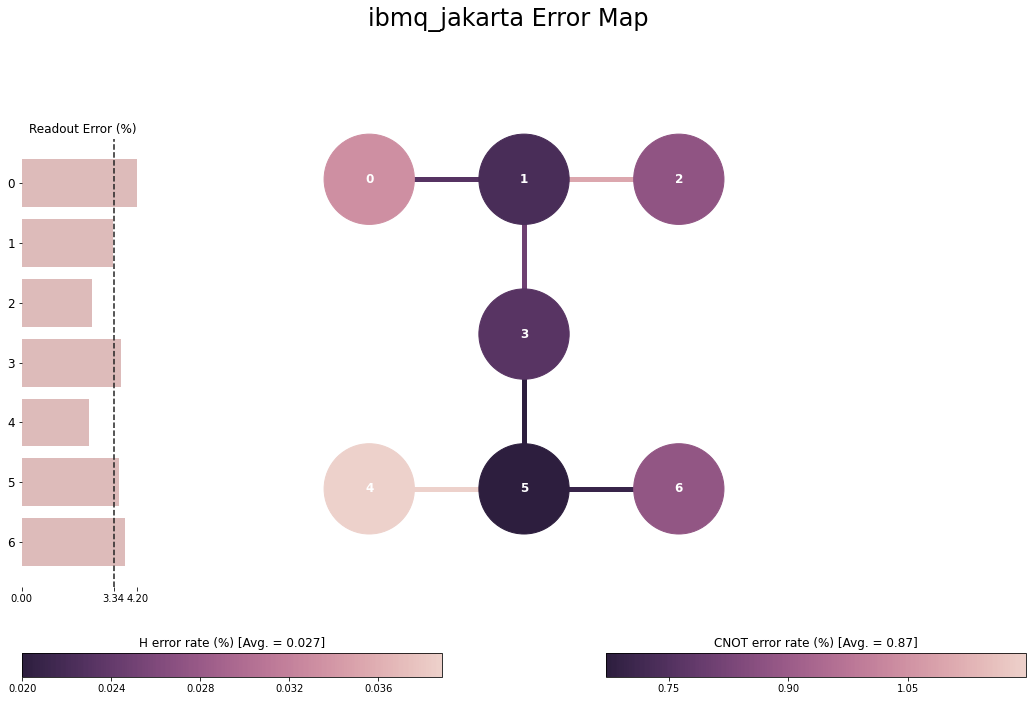

In [6]:
from qiskit.visualization import plot_error_map, plot_gate_map
%matplotlib inline

plot_error_map(backend, figsize=(18, 12))

In [7]:
from qiskit import Aer
def single_iter(n_qubits=2):
    iterate = QuantumCircuit(n_qubits)
    iterate.h(0)
    iterate.cx(0,1)
    iterate.cx(1,2)
    iterate.barrier()
    iterate.cx(1,2)
    iterate.cx(0,1)
    iterate.h(0)
    iterate.barrier()
    return iterate

def iterative_circ(num_itrs, n_qubits=2, save_den = True):   
    total_circ = QuantumCircuit(n_qubits)
    for i in range(num_itrs):
        total_circ.compose(single_iter(n_qubits), inplace=True)
    if save_den:
        total_circ.save_density_matrix(pershot=False)
    total_circ.measure_all()
    return total_circ

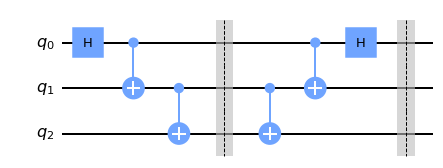

In [8]:
single_iter(n_qubits).draw("mpl")

In [9]:
temp_circ2 = iterative_circ(max_num_itrs, n_qubits, save_den = False)
temp_circ3 = transpile(temp_circ2, backend=backend)
print("Depth:", temp_circ3.depth())
print("T1:", backend.properties().qubit_property(0)['T1'][0], "sec")
print("T2:", backend.properties().qubit_property(0)['T2'][0], "sec")
dt = backend.configuration().dt # sec
temp_sch = schedule(temp_circ3, backend)
print("Circuit Operation Time:",(temp_sch.stop_time - temp_sch.start_time)*dt, "sec")

Depth: 101
T1: 0.00012638690371831915 sec
T2: 4.420988607509688e-05 sec
Circuit Operation Time: 1.6444444444444444e-05 sec


## Collect Measurement Data from Real Machine

In [10]:
job_list = []
for i in range(1, max_num_itrs+1):
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = False), backend=backend).copy(name=str(i))
    job_list.append(trans_circ)
iter_job = execute(job_list,shots=8192,backend=backend)
job_monitor(iter_job)

Job Status: job has successfully run


In [11]:
print(iter_job.job_id())  # 62a9bc6034dced9296906274

62a9bc6034dced9296906274


In [12]:
real_probs = [] # measurement result
for i in range(1, max_num_itrs+1):
    iter_res = iter_job.result()
    iter_vec = KSEM.dictToVec(iter_res.get_counts(str(i)))
    real_probs.append(iter_vec)
    
# Save to numpy
np.save(data_folder+backend.properties().to_dict()['backend_name']+'_meas_vec.npy',np.array(real_probs))

In [13]:
# Load
real_probs = np.load(data_folder+backend.properties().to_dict()['backend_name']+'_meas_vec.npy')

## Qiskit Backend-noise Simulation

Obtain measurement data and actual quantum states (from a backend-noise simulator)

Note that the outputs does not have measurement noise because the probabilities are obtained from density matrix object, instead of measurement operator API.

In [14]:
backend_noise_model = NoiseModel.from_backend(backend)
# # Remove readout errros
# p0given1 = 0
# p1given0 = 0
# rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
# for i in range(backend.configuration().num_qubits):
#     backend_noise_model._local_readout_errors[(i,)] = rde
den_simu = AerSimulator(method='density_matrix',noise_model=backend_noise_model)

In [54]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter,MeasurementFilter)
# Obtain Measurement Error Matrix
qr = QuantumRegister(n_qubits)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
for i in range(len(meas_calibs)):
    meas_calibs[i] = transpile(meas_calibs[i],den_simu)

job_meas = den_simu.run(meas_calibs,shots=reps*8192,optimization_level=0)
cal_results = job_meas.result()
meas_fitter = CompleteMeasFitter(cal_results,state_labels,circlabel='mcal')
meas_filter = meas_fitter.filter
cal_mat= meas_filter.cal_matrix
np.save(data_folder+backend.properties().to_dict()['backend_name']+'_cal_mat.npy', cal_mat)

In [16]:
cal_mat = np.load(data_folder+backend.properties().to_dict()['backend_name']+'_cal_mat.npy')
cal_mat

array([[9.32510376e-01, 4.35028076e-02, 4.28161621e-02, 1.93786621e-03,
        4.05883789e-02, 1.98364258e-03, 1.90734863e-03, 4.57763672e-05],
       [3.62701416e-02, 9.26193237e-01, 1.51062012e-03, 4.31518555e-02,
        1.67846680e-03, 3.90625000e-02, 6.10351562e-05, 1.99890137e-03],
       [2.01110840e-02, 8.69750977e-04, 9.09027100e-01, 4.37164307e-02,
        9.46044922e-04, 6.10351562e-05, 3.87115479e-02, 1.81579590e-03],
       [7.62939453e-04, 2.06298828e-02, 3.74145508e-02, 9.01702881e-01,
        4.57763672e-05, 1.11389160e-03, 1.84631348e-03, 3.92150879e-02],
       [9.65881348e-03, 3.35693359e-04, 4.27246094e-04, 1.52587891e-05,
        9.01000977e-01, 4.29077148e-02, 4.19616699e-02, 1.67846680e-03],
       [4.73022461e-04, 8.30078125e-03, 1.52587891e-05, 3.20434570e-04,
        3.54461670e-02, 8.94104004e-01, 1.64794922e-03, 4.09545898e-02],
       [2.13623047e-04, 0.00000000e+00, 8.48388672e-03, 3.66210938e-04,
        1.93023682e-02, 7.93457031e-04, 8.78601074e-01, 4.

In [17]:
unitary_simulator = Aer.get_backend('aer_simulator')
unitary_circ = transpile(single_iter(n_qubits), backend=den_simu)
unitary_circ.save_unitary()
unitary_result = unitary_simulator.run(unitary_circ).result()
unitary = unitary_result.get_unitary(unitary_circ)

unitaries = []
for i in range(1, max_num_itrs+1):
    gate = unitary.data
    F = np.kron(gate.conjugate(), gate)
    unitaries.append(F)

In [18]:
trans_circ = transpile(iterative_circ(3, n_qubits), backend=den_simu)
iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
iter_res.get_counts()

{'100': 712,
 '000': 55424,
 '010': 1628,
 '001': 6700,
 '111': 131,
 '101': 217,
 '011': 552,
 '110': 172}

In [19]:
np.random.seed(7)


total_simu_dens = [] # quantum state in density-matrix form
total_simu_probs = [] # measurement result
total_simu_purs = [] # purity
for i in range(1, max_num_itrs+1):
    trans_circ = transpile(iterative_circ(i, n_qubits), backend=den_simu)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
    iter_den = iter_res.data()['density_matrix']
    total_simu_dens.append(iter_den)
    total_simu_probs.append(KSEM.dictToVec(iter_res.get_counts()))
    total_simu_purs.append(np.real(iter_den.purity()))
    
print("Purity")
for pu in total_simu_purs:
    print(pu)
    
print("\nProb Vec")
for p in total_simu_probs:
    print(p)

Purity
0.9348910784467599
0.8766106692108713
0.824392608929799
0.7775582989062774
0.7355066426605279
0.6977051417958474
0.6636820167635837
0.6330192344833843
0.6053463383736326
0.5803349883792176

Prob Vec
[9.02465820e-01 6.05316162e-02 2.10113525e-02 4.05883789e-03
 8.98742676e-03 1.31225586e-03 8.23974609e-04 8.08715820e-04]
[0.87512207 0.07963562 0.02426147 0.00592041 0.00975037 0.00244141
 0.00134277 0.00152588]
[0.84825134 0.09954834 0.02586365 0.00894165 0.01010132 0.00309753
 0.00218201 0.00201416]
[0.8223877  0.11802673 0.02716064 0.01147461 0.01072693 0.00442505
 0.00289917 0.00289917]
[0.79847717 0.1343689  0.02888489 0.01448059 0.01141357 0.00497437
 0.00382996 0.00357056]
[0.77459717 0.15298462 0.02996826 0.0158844  0.01200867 0.0059967
 0.00473022 0.00382996]
[0.75242615 0.16801453 0.03117371 0.01898193 0.01246643 0.00724792
 0.00488281 0.00480652]
[0.7322998  0.18170166 0.03495789 0.02005005 0.0128479  0.00735474
 0.00541687 0.00537109]
[0.71153259 0.19509888 0.03573608 0

## Kalman Smoother

In [20]:
def vecden_meas(state):# H, measurement matrix for vectorized density matrix
    num_qubits = int(np.log2(np.sqrt(state.shape[0])))
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = np.zeros((nrows, ncols), dtype=np.float64)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1.0 # take out the diagonal terms in vectorized density matrix
    return np.real(mat.dot(state))

### Initialize

In [21]:
real_probs

array([[0.89758301, 0.03894043, 0.0222168 , 0.01171875, 0.01342773,
        0.0090332 , 0.00500488, 0.0020752 ],
       [0.82995605, 0.08154297, 0.03112793, 0.01245117, 0.01806641,
        0.01318359, 0.01220703, 0.00146484],
       [0.73706055, 0.13696289, 0.0456543 , 0.02075195, 0.01928711,
        0.00830078, 0.0234375 , 0.00854492],
       [0.60876465, 0.19970703, 0.06298828, 0.03820801, 0.01794434,
        0.01586914, 0.0435791 , 0.01293945],
       [0.50280762, 0.25610352, 0.07714844, 0.04748535, 0.02612305,
        0.02197266, 0.04882812, 0.01953125],
       [0.42407227, 0.27209473, 0.08056641, 0.07128906, 0.02502441,
        0.02404785, 0.06982422, 0.03308105],
       [0.29614258, 0.33679199, 0.09069824, 0.08825684, 0.03039551,
        0.02392578, 0.08117676, 0.0526123 ],
       [0.2232666 , 0.36364746, 0.10375977, 0.09887695, 0.03686523,
        0.03344727, 0.08166504, 0.05847168],
       [0.17602539, 0.34313965, 0.0994873 , 0.1361084 , 0.03979492,
        0.0390625 , 0.089599

In [22]:
initial_state = np.array([0]*(real_probs[0].size**2), dtype=complex)
initial_state[0] = 1

# initial state
num_dim = initial_state.size
x =initial_state
x[0]-= 0.01/num_dim
nrows = int(x.size-1)
for k in range(1,nrows+1):
    x[k] += 1/(num_dim*nrows)

In [43]:
# Other variance parameters
num_dim_state = initial_state.size
num_dim_obs = real_probs[0].size

M = np.identity(num_dim_state, dtype=complex)* 0.01 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
R = np.identity(num_dim_obs)* 0.2 * (1) # meas covariance
P = np.identity(num_dim_state, dtype=complex)* 0.1 * (1+1j)# 
# U = np.identity(num_dim_obs, dtype=complex)* 0.0

In [44]:
x.size,num_dim_state,num_dim_obs, unitaries[0].size

(64, 64, 8, 4096)

### EM and Smoother - Total

Use longest iterations

In [45]:
total_smoother_dens = []
total_smoother_purs = []

observs = real_probs
learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented

# Slice from argumented system
realX0 = estX0.toarray()[:num_dim_state]
realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

smoother = KSQS(observs, realF, x, realM0, realQ, realR, realP)
x_seq, M_seq, M_prio_seq = smoother.smooth() 

x_est_norms = []
for j in range(max_num_itrs):
#     x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
#     diag_sum = np.sum(vecden_meas(x_est))

#     #normalize along the diagonal
#     x_est_norm = x_est+0
#     nrows = int(np.sqrt(x_est.size))
#     for k in range(nrows):
#         x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
#     x_est_norms.append(x_est_norm)
#     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))
    x_est = np.matrix(x_seq[j+1][:num_dim_state].todense()).flatten().reshape(num_dim_obs, num_dim_obs)
#     x_est = (x_est+x_est.H)/2
    final_den = KSEM.closed_den_mat(x_est)
    total_smoother_dens.append(final_den)
    total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Iteration statrts New ll 913.75, Last ll 903.75
Iteration     1, New log-likelihood 9.22336e+02, Last log-likelihood 9.13748e+02, Change 8.58738e+00
Iteration     2, New log-likelihood 2.85763e+06, Last log-likelihood 9.22336e+02, Change 2.85671e+06


Only use the estimation in the final iteration as the valid output

In [46]:
# total_smoother_dens = []
# total_smoother_purs = []
# for i in range(1,max_num_itrs+1):
#     observs = real_probs[0:i]
#     learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
#     estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented
    
#     # Slice from argumented system
#     realX0 = estX0.toarray()[:num_dim_state]
#     realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
#     realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
#     realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

#     smoother = KSQS(observs, realF, x, realM0, realQ, realR, realP)
#     x_seq, M_seq, M_prio_seq = smoother.smooth() 
    
#     # Normalization
# #     x_est_norms = []
# #     for j in range(i):
# #         x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
# #         diag_sum = np.sum(vecden_meas(x_est))

# #         #normalize along the diagonal
# #         x_est_norm = x_est+0
# #         nrows = int(np.sqrt(x_est.size))
# #         for k in range(nrows):
# #             x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
# #     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)

#     x_est = np.matrix(x_seq[-1][:num_dim_state].todense()).flatten().reshape(num_dim_obs, num_dim_obs)
#     x_est = (x_est+x_est.H)/2
#     final_den = KSEM.closed_den_mat(x_est)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

In [47]:
for den in total_smoother_dens:
    print("Is state a valid density matrix:", qi.DensityMatrix(den).is_valid())

Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True


In [48]:
with np.printoptions(precision=3, suppress=True):
#     for den in total_smoother_dens:
#         print(den)
    print(total_smoother_dens[8])
    print(total_simu_dens[8].data)

[[ 0.273-0.j     0.   -0.j    -0.   -0.j    -0.   -0.j    -0.   -0.j
  -0.   -0.j    -0.   -0.j    -0.   -0.j   ]
 [ 0.   +0.j     0.182-0.j    -0.   +0.j    -0.   +0.j    -0.   +0.j
  -0.   +0.j    -0.   +0.j    -0.   +0.j   ]
 [-0.   +0.j    -0.   -0.j     0.   -0.j    -0.   -0.j    -0.   +0.j
  -0.   +0.j    -0.   -0.j    -0.   -0.j   ]
 [-0.   +0.j    -0.   -0.j    -0.   +0.j     0.163+0.j    -0.   +0.j
  -0.   +0.j     0.   +0.j     0.   +0.001j]
 [-0.   +0.j    -0.   -0.j    -0.   -0.j    -0.   -0.j     0.15 -0.j
   0.   +0.j     0.   -0.j    -0.   -0.j   ]
 [-0.   +0.j    -0.   -0.j    -0.   -0.j    -0.   -0.j     0.   -0.j
   0.066-0.j     0.   -0.j    -0.   -0.j   ]
 [-0.   +0.j    -0.   -0.j    -0.   +0.j     0.   -0.j     0.   +0.j
   0.   +0.j     0.   +0.j     0.   -0.j   ]
 [-0.   +0.j    -0.   -0.j    -0.   +0.j     0.   -0.001j -0.   +0.j
  -0.   +0.j     0.   +0.j     0.166+0.j   ]]
[[ 0.756+0.j  0.024+0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j
   0.   +0.j  0.   

In [49]:
print("Estimated Purity (Total)")
for pu in total_smoother_purs:
    print(pu)

Estimated Purity (Total)
0.7902044923296424
0.6869984580657629
0.5776412631405151
0.4262088169484962
0.3193847657214393
0.2815453150068762
0.2798678953022595
0.2138794602532176
0.18869537525230667
0.21526533924674096


## Check the fidelity between estimated state and the real state in the simulator

In [50]:
from scipy.linalg import sqrtm
def state_fid(m1,m2):
    sqm1 = sqrtm(m1)
    temp = sqm1.dot(m2).dot(sqm1)
    temp2 = sqrtm(temp)
    return np.real(np.trace(temp2))**2

def dist(p,q):
    return np.abs(p-q).sum()*0.5

Iteration 1 KS Dist: 0.0761067767401527 Simu Dist: 0.06895836129022305
Iteration 2 KS Dist: 0.08600792344618019 Simu Dist: 0.10494067984780577
Iteration 3 KS Dist: 0.03830752183450068 Simu Dist: 0.1678949932281111
Iteration 4 KS Dist: 0.09271570992008528 Simu Dist: 0.267859839285261
Iteration 5 KS Dist: 0.11896647780836285 Simu Dist: 0.34700111561655583
Iteration 6 KS Dist: 0.15492483476211086 Simu Dist: 0.40034849190485977
Iteration 7 KS Dist: 0.2060272421642092 Simu Dist: 0.5042356240675314
Iteration 8 KS Dist: 0.17676815030562204 Simu Dist: 0.5543369579900215
Iteration 9 KS Dist: 0.3201263282198754 Simu Dist: 0.5799984967090916
Iteration 10 KS Dist: 0.25715850716004734 Simu Dist: 0.5962883112189349


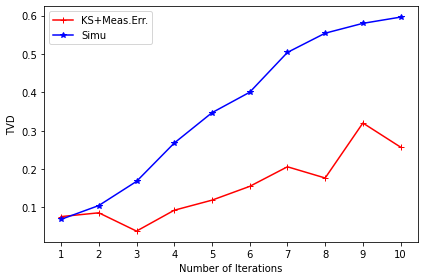

In [59]:
diff_fed_all= []
diff_fed_simu= []
for i in range(max_num_itrs):
    fed_difference_simu =  dist(real_probs[i].data, total_simu_dens[i].probabilities())
    KS_vec = np.array(total_smoother_dens[i].diagonal()).flatten().real
    noisy_KS_vec = cal_mat.dot(KS_vec)
    fed_difference_all =  dist(real_probs[i].data, noisy_KS_vec)
    diff_fed_all.append(fed_difference_all)
    diff_fed_simu.append(fed_difference_simu)
    print("Iteration",i+1, "KS Dist:", fed_difference_all, "Simu Dist:", fed_difference_simu)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS+Meas.Err.')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_simu)[iter_range], '*-', color='blue', label='Simu')
plt.xlabel("Number of Iterations")
plt.ylabel("TVD")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.savefig(data_folder+backend.properties().to_dict()['backend_name']+"_diff_dist.svg")
plt.show()

In [52]:
np.sum(diff_fed_all)

1.526426632224508